In this notebook, we load the preprocessed dataset as created in 'Project_preprocessing' and build a Support Vector Regressor model. The preprocessed dataset is split into train and test sets. <br>
1. Naive Baseline - Predictions on the test set are performed using 'Naive Baseline' model (mean strategy). The baseline Root mean square error (RMSE) is thus established.
2. Default model - The default Support Vector Regressor model is evaluated with 5 fold cross validation on train set. The model is then fit on the entire train data and predictions are performed on test data. RMSE using default model on test data is reported.
3. Tuned model - Lastly, we optimize the parameters of the model using 5 cross validation. An extensive parameter search is performed using several grid searches. 'neg_root_mean_squared_error' is used as scoring function during grid search. The 'best estimator' model obtained after grid searches with 5 fold cross validation is finally used to perform predictions on the test set. RMSE obtained using tuned model on test set is compared with that of Default model and Naive Baseline model.
4. Finally, we reduce dimensions using PCA, repeat steps 2 & 3 above and compare RMSE scores.  

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
#read preprocessed dataset as pandas dataframe
dataset = pd.read_csv('melbourne-airbnb.csv')

In [53]:
#examine first 5 rows
dataset.head()

,accommodates,bedrooms,guests_included,bathrooms,cleaning_fee,security_deposit,longitude,suburb_rank,price,host_is_superhost_t,...,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,cancellation_policy_moderate,cancellation_policy_strict,Air_Conditioning_True,Free_Parking_True,Family_kid_friendly_True
0,2,1.0,1,1.0,59.0,200.0,145.092133,133.0,60,0,...,0,0,0,1,0,0,1,0,0,0
1,2,1.0,1,1.0,9.0,0.0,144.980736,44.0,35,0,...,0,0,0,1,0,1,0,1,0,1
2,3,1.0,2,1.0,100.0,450.0,144.977369,26.0,159,1,...,0,0,0,0,0,0,1,1,1,1
3,1,1.0,1,1.5,15.0,200.0,144.989228,84.0,50,0,...,0,0,0,1,0,1,0,0,1,0
4,2,1.0,1,1.0,15.0,200.0,144.992238,28.0,69,0,...,0,0,0,1,0,1,0,0,0,0


In [54]:
#split into a features dataframe and target series
X = dataset.drop('price',axis=1)
y = dataset['price']

In [55]:
#split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Naive Baseline

In [56]:
#create naive baseline
from sklearn.metrics import mean_squared_error, r2_score
mean_price = np.mean(y)
y_test_naive = np.repeat(mean_price, len(y_test))
naive_rmse = mean_squared_error(y_test, y_test_naive)
naive_rmse = np.sqrt(naive_rmse)
naive_r2 = r2_score(y_test,y_test_naive)
print('Naive Baseline RMSE on test set: ' + str(round(naive_rmse,2)))
print('Naive Baseline R2 on test set: ' + str(round(naive_r2,2)))

Naive Baseline RMSE on test set: 75.75
Naive Baseline R2 on test set: -0.0


## Support Vector Machine - Default parameters

Support Vector machines are based on a distance metric, therefore they require the data to be scaled for optimal performance. We will perform 'RobustScaling' as we have some outliers in the dataset. Also, we will perform a transformation of scaled data to reduce skewness. The steps of scaling and transformation will be included in the machine learning pipeline. 

In [57]:
#evaluate svr with default parameters on test set
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

steps = [('scaler', RobustScaler()),('transformer', PowerTransformer(method='yeo-johnson')), ('SVR', SVR())]
pipeline = Pipeline(steps)

# evaluate default model with 5 fold cross validation on train set
scores = cross_val_score(pipeline,X_train,y_train, cv=5, scoring='neg_root_mean_squared_error')
mean_score = abs(np.mean(scores))

#fit model on entire train set and predict on test set
pipeline.fit(X_train,y_train)
y_pred_def = pipeline.predict(X_test)

# evaluate predictions made on test set
svr_def_r2 = r2_score(y_test,y_pred_def)
svr_def_rmse = np.sqrt(mean_squared_error(y_test, y_pred_def))

print('SVR (default parameters) mean cross validated RMSE on train set: ' + str(round(mean_score,2)))
print()
print('SVR (default parameters) R2 score on test set: ' + str(round(svr_def_r2,1)))
print()
print('SVR (default parameters) RMSE score on test set: ' + str(round(svr_def_rmse,2)))

SVR (default parameters) mean cross validated RMSE on train set: 60.63

SVR (default parameters) R2 score on test set: 0.4

SVR (default parameters) RMSE score on test set: 58.09


## Support Vector Machine - hyperparameter optimization
Perform hyperparameter tuning using grid search with 5 fold cross validation on train set. Evaluate tuned model on test set and calculate RMSE.  

In [58]:
from sklearn.model_selection import GridSearchCV

steps = [('scaler', RobustScaler()),('transformer', PowerTransformer(method='yeo-johnson')), ('SVR', SVR())]
pipeline = Pipeline(steps)

#define hyperparameters to tune
parameters = {'SVR__kernel': ['linear'], 'SVR__C':[1,10,100], 'SVR__gamma':[1.0,0.01,0.001]}

#perform grid search using cross validation
grid1_lin = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='neg_root_mean_squared_error')
grid1_lin.fit(X_train, y_train)
print('Best parameters with grid1')
print(grid1_lin.best_params_)

Best parameters with grid1
{'SVR__C': 100, 'SVR__gamma': 1.0, 'SVR__kernel': 'linear'}


In [59]:
grid1_rmse = abs(grid1_lin.best_score_)
best_std = grid1_lin.cv_results_['std_test_score'][grid1_lin.best_index_]
print('Mean cross validated RMSE with best estimator grid1: '+ str(round(grid1_rmse,2)) + ', Standard deviation: ' + str(round(best_std,2)))

Mean cross validated RMSE with best estimator grid1: 59.6, Standard deviation: 1.15


In [60]:
#further tuning of parameters
steps = steps = [('scaler', RobustScaler()),('transformer', PowerTransformer(method='yeo-johnson')), ('SVR', SVR())]
pipeline = Pipeline(steps)

#define hyperparameters to tune
parameters = {'SVR__kernel': ['rbf'],'SVR__C':[1,10,100], 'SVR__gamma':[1.0,0.01,0.001]}

#perform grid search using cross validation
grid2_rbf = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='neg_root_mean_squared_error')
grid2_rbf.fit(X_train, y_train)
print('Best parameters with grid2')
print(grid2_rbf.best_params_)

Best parameters with grid2
{'SVR__C': 100, 'SVR__gamma': 0.01, 'SVR__kernel': 'rbf'}


In [61]:
grid2_rmse = abs(grid2_rbf.best_score_)
best_std = grid2_rbf.cv_results_['std_test_score'][grid2_rbf.best_index_]
print('Mean cross validated RMSE with best estimator grid2: '+ str(round(grid2_rmse,2)) + ', Standard deviation: ' + str(round(best_std,2)))

Mean cross validated RMSE with best estimator grid2: 55.02, Standard deviation: 1.3


In [62]:
#predict using model with tuned hyperparameters
y_pred_rbf = grid2_rbf.predict(X_test)
rbf_r2 = r2_score(y_test,y_pred_rbf)
rbf_rmse = mean_squared_error(y_test, y_pred_rbf)
rbf_rmse = np.sqrt(rbf_rmse)
print('R2 score using tuned SVR(rbf) on test set: ' + str(round(rbf_r2,1)))
print()
print('RMSE using tuned SVR(rbf) on test set: ' + str(round(rbf_rmse,2)))

R2 score using tuned SVR(rbf) on test set: 0.5

RMSE using tuned SVR(rbf) on test set: 53.62


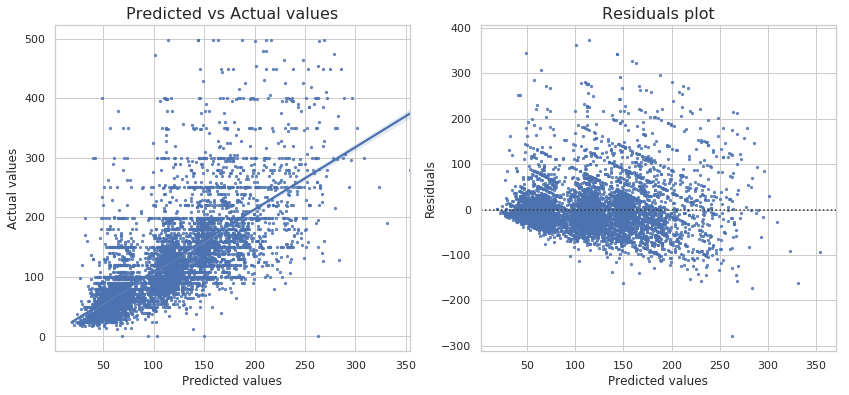

In [63]:
#plot predicted vs actual values and residuals plot

residuals = y_test-y_pred_rbf

sns.set(style="whitegrid")
fig,(ax1,ax2) = plt.subplots(1,2, figsize= (14,6))
sns.regplot(x = y_pred_rbf, y=y_test,scatter_kws={'s':5}, ax=ax1)
ax1.set_xlabel('Predicted values',fontsize=12)
ax1.set_ylabel('Actual values',fontsize=12)
ax1.set_title('Predicted vs Actual values', fontsize = 16)
sns.residplot(x=y_pred_rbf, y=residuals,scatter_kws={'s':5}, ax=ax2)
ax2.set_xlabel('Predicted values',fontsize=12)
ax2.set_ylabel('Residuals',fontsize=12)
ax2.set_title('Residuals plot', fontsize=16);

## Support Vector Machine - Reduced Dimensions

In this section, we will reduce dimensions using Principal Component Analysis and then evaluate the performance of SVR models (default and after tuning of hyperparameters). We will first choose the number of principal components based on explained variance and then include PCA as a step in the machine learning pipeline.

In [64]:
#perform PCA on dataset to determine optimal number of components
from sklearn.decomposition import PCA
scaler = RobustScaler() #since our dataset has a few outliers, this is a better scaling model than StandardScaler()

X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit_transform(X_scaled)

array([[-1.16732881,  1.93101   ,  2.69969197, ...,  0.01450671,
        -0.02422651, -0.01806251],
       [-3.10244425, -1.04505631, -0.13563618, ..., -0.19636286,
         0.0304761 , -0.05869694],
       [ 2.81031508, -0.26824563, -0.57746188, ..., -0.07570486,
         0.00487999, -0.00743788],
       ...,
       [-1.07919806,  2.55443757, -1.1958772 , ...,  0.28055139,
         0.03351262, -0.00812969],
       [ 0.41997967, -1.19986495, -1.03192208, ..., -0.04591324,
        -0.01481001, -0.00546613],
       [-0.22225769, -1.2179401 , -1.44071904, ..., -0.09013047,
        -0.04371651,  0.00655015]])

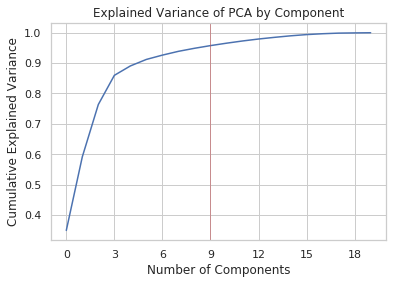

In [65]:
#function to draw scree plot (explained variance by principal components)
def var_explained():
    import numpy as np
    from matplotlib.pyplot import figure, show
    from matplotlib.ticker import MaxNLocator

    ax = figure().gca()
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axvline(x=9, linewidth=1, color='r', alpha=0.5)
    plt.title('Explained Variance of PCA by Component')
    show()

var_explained()

We can account for ~95% of variance if we select 9 principal components.

## SVR (default parameters) after PCA
An important preprocessing step before reducing dimensions with PCA is to scale the data. Since our dataset has some outliers, we will use RobustScaler() method. Also, we will perform a transformation of scaled data to reduce skewness and then reduce dimensions using PCA. The steps of scaling,transformation and PCA will be included in the machine learning pipeline. 

In [66]:
#reduce dimensions using PCA and then evaulate SVR model
steps = [('scaler', RobustScaler()),('pca',PCA(n_components=9)),('SVR', SVR())]
pipeline = Pipeline(steps)

# evaluate default model with 5 fold cross validation on train set
scores = cross_val_score(pipeline,X_train,y_train, cv=5, scoring='neg_root_mean_squared_error')
mean_score = abs(np.mean(scores))

#fit model on entire train set and predict on test set
pipeline.fit(X_train,y_train)
y_pred_def = pipeline.predict(X_test)

# evaluate predictions made on test set
svr_def_r2_pca = r2_score(y_test,y_pred_def)
svr_def_rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_def))

print('SVR(default parameters) mean cross validated RMSE on train set after PCA: ' + str(round(mean_score,2)))
print()
print('SVR (default parameters) R2 score on test set after PCA: ' + str(round(svr_def_r2_pca,1)))
print()
print('SVR (default parameters) RMSE score on test set after PCA: ' + str(round(svr_def_rmse_pca,2)))

SVR(default parameters) mean cross validated RMSE on train set after PCA: 61.45

SVR (default parameters) R2 score on test set after PCA: 0.4

SVR (default parameters) RMSE score on test set after PCA: 58.7


## SVR (hyperparameters tuned) after PCA

In [67]:
#reduce dimensions using PCA and then perform grid search to tune hyperparameters 
steps = [('scaler', RobustScaler()),('pca',PCA(n_components=9)),('SVR', SVR(kernel='rbf'))]
pipeline = Pipeline(steps)
parameters = {'SVR__C':[1,10,100], 'SVR__gamma':[1.0,0.01,0.001]}
grid_rbf_pca = GridSearchCV(pipeline, param_grid=parameters, cv=5,scoring='neg_root_mean_squared_error')
grid_rbf_pca.fit(X_train, y_train)
print('Best parameters after PCA: ')
print(grid_rbf_pca.best_params_)

Best parameters after PCA: 
{'SVR__C': 100, 'SVR__gamma': 0.01}


In [68]:
grid_pca_rmse = abs(grid_rbf_pca.best_score_)
best_std = grid_rbf_pca.cv_results_['std_test_score'][grid_rbf_pca.best_index_]
print('Mean cross validated RMSE with best estimator after PCA: '+ str(round(grid_pca_rmse,2)) + ', Standard deviation: ' + str(round(best_std,2)))

Mean cross validated RMSE with best estimator after PCA: 56.51, Standard deviation: 1.23


In [69]:
y_pred_pca = grid_rbf_pca.predict(X_test)
pca_r2 = r2_score(y_test,y_pred_pca)
pca_rmse = mean_squared_error(y_test, y_pred_pca)
pca_rmse = np.sqrt(pca_rmse)
print('R2 score using SVR(rbf) after PCA: ' + str(round(pca_r2,1)))
print()
print('RMSE using SVR(rbf) after PCA: ' + str(round(pca_rmse,2)))

R2 score using SVR(rbf) after PCA: 0.5

RMSE using SVR(rbf) after PCA: 54.9


Reducing dimensions with PCA resulted in a slightly lower performance of the default and tuned models on test set, as compared to the respective models' performances without PCA. 

In [70]:
#final summary
print('Summarizing: ')
print()
print('Naive Baseline RMSE on test set: ' + str(round(naive_rmse,2)))
print()
print('SVR (default parameters) RMSE on test set: ' + str(round(svr_def_rmse,2)))
print()
print('SVR(tuned parameters) RMSE on test set: ' + str(round(rbf_rmse,2)))
print()
print('SVR (default parameters) RMSE on test set after PCA: ' + str(round(svr_def_rmse_pca,2)))
print()
print('SVR(tuned parameters) RMSE on test set after PCA: ' + str(round(pca_rmse,2)))



Summarizing: 

Naive Baseline RMSE on test set: 75.75

SVR (default parameters) RMSE on test set: 58.09

SVR(tuned parameters) RMSE on test set: 53.62

SVR (default parameters) RMSE on test set after PCA: 58.7

SVR(tuned parameters) RMSE on test set after PCA: 54.9
